In [1]:
!pip install torch torchvision torchaudio


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Verificar si GPU está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


In [4]:
# Parámetros de difusión
T = 1000  # Número de pasos de difusión
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)

# Cálculo de alphas y sqrt(1-beta)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

In [5]:
import torch
import torch.nn as nn

# Modelo CNN mejorado
class ImprovedCNNModel(nn.Module):
    def __init__(self, input_channels=3, hidden_channels=64, image_size=64):
        super(ImprovedCNNModel, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)  # Normalización por lotes
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels)

        # Max pooling para reducir la dimensionalidad
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_channels * 2)
        self.conv4 = nn.Conv2d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_channels * 2)

        # Max pooling adicional
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa totalmente conectada final para reconstruir la imagen
        self.fc = nn.Linear((hidden_channels * 2) * (image_size // 4) * (image_size // 4), image_size * image_size * input_channels)

    def forward(self, x):
        # Capa convolucional + activación + batch norm + pooling
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = torch.relu(self.bn2(self.conv2(x)))

        # Segunda capa convolucional + activación + batch norm + pooling
        x = self.pool2(torch.relu(self.bn3(self.conv3(x))))
        x = torch.relu(self.bn4(self.conv4(x)))

        # Aplanar para la capa completamente conectada
        x = x.view(x.size(0), -1)  # Flatten (batch_size, features)

        # Reconstruir imagen
        x = self.fc(x)
        x = x.view(x.size(0), 3, 64, 64)  # Volver al tamaño original de la imagen (64x64x3)
        return x

# Ruido gaussiano
def sample_noise(shape):
    """Genera ruido gaussiano con forma especificada."""
    return torch.randn(shape).to(device)

# Función de pérdida MSE o L1
def loss_fn(x, y, loss_type='mse'):
    """Calcula la pérdida entre las predicciones y los valores reales."""
    if loss_type == 'mse':
        return torch.mean((x - y) ** 2)  # MSE (pérdida cuadrática media)
    elif loss_type == 'l1':
        return torch.mean(torch.abs(x - y))  # L1 (pérdida absoluta media)



In [6]:
# Montar Google Drive si usas datos de allí
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!unzip /content/drive/MyDrive/dataset_imagenes_personajes_anime.zip -d /content/mi_dataset


Archive:  /content/drive/MyDrive/dataset_imagenes_personajes_anime.zip
replace /content/mi_dataset/anime_links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
ls -1a /content/mi_dataset/dataset/dataset | wc -l


58087


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import numpy as np

# Establecer la semilla para reproducibilidad
seed = 42
torch.manual_seed(seed)

# Transformaciones: Redimensionar imágenes y convertir a tensor (y normalización opcional)
transform = transforms.Compose([
    transforms.Resize((64, 64)),      # Cambia el tamaño de las imágenes según tu preferencia
    transforms.ToTensor(),            # Convertir la imagen a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar valores de los píxeles (opcional, pero recomendado)
])


# Cargar las imágenes desde la carpeta con una subcarpeta para la única clase
dataset = datasets.ImageFolder(root='/content/mi_dataset/dataset', transform=transform)

# Cantidad total de imágenes en el dataset
dataset_size = len(dataset)

# Número de imágenes que quieres tomar de forma aleatoria
num_samples = 5000  # Cambia este número según cuántas imágenes quieres seleccionar

# Crear un índice aleatorio para seleccionar el subconjunto de imágenes
indices = list(range(dataset_size))
np.random.seed(seed)  # Fijar la semilla para numpy también
np.random.shuffle(indices)  # Barajar los índices

# Tomar solo los primeros "num_samples" índices
subset_indices = indices[:num_samples]

# Crear el sampler con los índices seleccionados
sampler = torch.utils.data.SubsetRandomSampler(subset_indices)

# Crear DataLoader usando el sampler
dataloader = DataLoader(dataset, batch_size=64, sampler=sampler)

# Ejemplo de obtener un lote de imágenes
images, _ = next(iter(dataloader))
print(images.shape)  # Verifica el tamaño de las imágenes seleccionadas




torch.Size([64, 3, 64, 64])


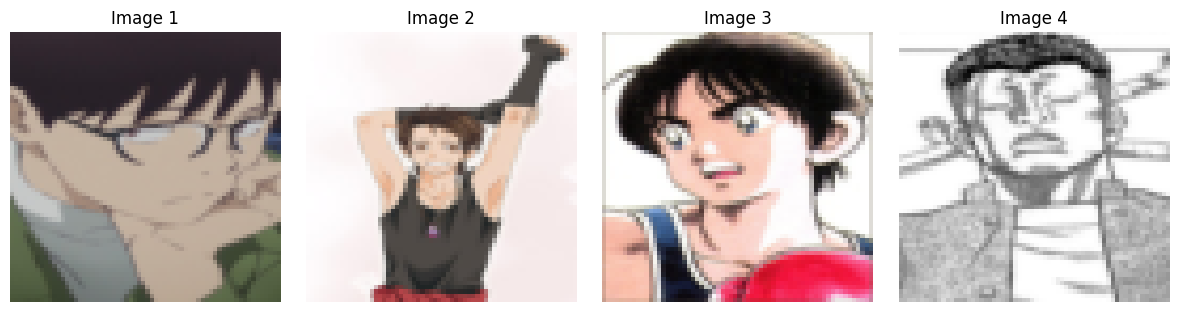

In [10]:
# Función para mostrar imágenes del DataLoader
def show_images(dataloader, num_images=8):
    # Obtener un lote de imágenes del DataLoader
    batch = next(iter(dataloader))
    images, labels = batch

    # Denormalizar las imágenes para mostrarlas correctamente
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    images = images.numpy() * std[:, None, None] + mean[:, None, None]
    images = np.clip(images, 0, 1)  # Asegurar que los valores estén en el rango correcto

    # Mostrar las imágenes en una cuadrícula
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Cambiar el orden de los canales para mostrar en RGB
        plt.axis('off')
        plt.title(f'Image {i + 1}')
    plt.tight_layout()
    plt.show()

# Mostrar algunas imágenes del dataset
show_images(dataloader, num_images=4)

In [11]:
# Proceso inverso de difusión para generar imágenes
def sample_from_diffusion(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        # Inicializamos con ruido gaussiano (normal) de tamaño (num_samples, 64*64*3)
        samples = sample_noise((num_samples, 64*64*3)).to(device)

        # Proceso de muestreo inverso, recorremos los pasos de T a 0
        for t in reversed(range(T)):
            z = sample_noise(samples.shape).to(device) if t > 0 else 0
            predicted_noise = model(samples)

            # Actualizar los samples usando el paso de difusión inverso
            samples = (samples - betas[t] * predicted_noise) / torch.sqrt(alphas[t]) + sqrt_one_minus_alphas_cumprod[t] * z

    return samples

In [ ]:
import torch
from tqdm import tqdm  # Barra de progreso
import matplotlib.pyplot as plt

# Función de entrenamiento con progreso y generación de imágenes
def train_diffusion_model(model, optimizer, dataloader, epochs=1000, display_every=100):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")

        for i, (x, _) in progress_bar:
            x = x.to(device)

            # Paso de difusión aleatorio
            t = torch.randint(0, T, (1,), device=device).long()
            noise = sample_noise(x.shape)

            # Agregar ruido
            noisy_x = alphas_cumprod_prev[t] * x + sqrt_one_minus_alphas_cumprod[t] * noise

            # Predicción del modelo
            predicted_noise = model(noisy_x)

            # Calcular pérdida
            loss = loss_fn(noise, predicted_noise)

            # Retropropagación
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Acumular la pérdida total de la época
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Imprimir pérdida al final de cada epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")

        # Generar y mostrar imágenes cada 'display_every' epochs
        if (epoch + 1) % display_every == 0:
            generated_samples = sample_from_diffusion(model).cpu().detach()
            generated_samples = generated_samples.view(-1, 3, 64, 64)  # Restaurar a imágenes 64x64x3

            # Mostrar las primeras 8 imágenes generadas
            fig, axes = plt.subplots(1, 8, figsize=(20, 5))
            for i in range(8):
                axes[i].imshow(generated_samples[i].permute(1, 2, 0))  # Reordenar a formato HWC
                axes[i].axis('off')
            plt.show()

# Crear el modelo y transferirlo a la GPU
model = ImprovedCNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-2)

# Entrenar el modelo con el dataloader de tu dataset
train_diffusion_model(model, optimizer, dataloader, epochs=200, display_every=20)




Epoch 1/200: 100%|██████████| 79/79 [00:27<00:00,  2.92it/s, loss=1.01]


Epoch 1/200, Loss: 3141.0154352580444


Epoch 2/200: 100%|██████████| 79/79 [00:26<00:00,  2.96it/s, loss=1.01]


Epoch 2/200, Loss: 1.000128681901135


Epoch 3/200: 100%|██████████| 79/79 [00:26<00:00,  2.96it/s, loss=1]


Epoch 3/200, Loss: 1.000139001049573


Epoch 4/200: 100%|██████████| 79/79 [00:26<00:00,  2.95it/s, loss=1.01]


Epoch 4/200, Loss: 1.0002636713317679


Epoch 5/200: 100%|██████████| 79/79 [00:26<00:00,  2.97it/s, loss=1]


Epoch 5/200, Loss: 1.0001946174645726


Epoch 6/200: 100%|██████████| 79/79 [00:26<00:00,  2.95it/s, loss=1.01]


Epoch 6/200, Loss: 1.0003581092327456


Epoch 7/200:  18%|█▊        | 14/79 [00:04<00:24,  2.68it/s, loss=0.999]